In [3]:
import string
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
# NLTK
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from source import my_tokenizer

This is the main preprocessing notebook. I will use TF-IDF to vectorise the words, using a custom tokeniser to remove stop words, small inconsietnecies in the text, as well as understanding what words are not in the english language.

In [4]:
nltk.download('wordnet')
nltk.download('words')

[nltk_data] Downloading package wordnet to /Users/edo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to /Users/edo/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [5]:
df = pd.read_csv("../data/clean_technology_reviews.csv", index_col=0)

Dropping duplicated reviews that arise through dropping metadata columns.

In [6]:
df["reviewText"].duplicated().sum()

170770

In [7]:
df = df.drop_duplicates(ignore_index=True, subset="reviewText")

In [8]:
df.head(10)

,overall,reviewText,asin,length
0,5.0,Looks even better in person. Be careful to not...,7508492919,271
1,5.0,When you don't want to spend a whole lot of ca...,7508492919,102
2,3.0,"so the case came on time, i love the design. I...",7508492919,257
3,2.0,DON'T CARE FOR IT. GAVE IT AS A GIFT AND THEY...,7508492919,92
4,4.0,"I liked it because it was cute, but the studs ...",7508492919,150
5,2.0,The product looked exactly like the picture an...,7508492919,159
6,3.0,I FINALLY got my case today. It took forever t...,7508492919,344
7,5.0,It is a very cute case. None of the jewels hav...,7508492919,327
8,1.0,DO NOT BUY! this item is seriously cheap as he...,7508492919,190
9,4.0,I really love this case... you have to keep yo...,7508492919,188


In [9]:
pd.DataFrame(np.unique(df['overall'], return_counts=True)).T.set_index(0)

,1
0,
1.0,69133.0
2.0,48552.0
3.0,78994.0
4.0,134058.0
5.0,474074.0


Adding length of reviews to each review

In [10]:
rev_len = list()
for review in df["reviewText"]:
    rev_len.append(len(str(review)))

In [11]:
df["length"] = rev_len

In [12]:
df["length"].describe()

count    804811.000000
mean        247.052657
std         385.543778
min           1.000000
25%          62.000000
50%         136.000000
75%         282.000000
max       33457.000000
Name: length, dtype: float64

In [13]:
shorter = df[df["length"]<=500].copy()


In [14]:
shorter["reviewText"].fillna("", inplace=True)

In [15]:
shorter = shorter.reset_index(drop='index')

In [17]:
shorter["binary"]= np.where(shorter['overall']>3, 1, 0)

In [19]:
shorter.head(10)

,overall,reviewText,asin,length,binary
0,5.0,Looks even better in person. Be careful to not...,7508492919,271,1
1,5.0,When you don't want to spend a whole lot of ca...,7508492919,102,1
2,3.0,"so the case came on time, i love the design. I...",7508492919,257,0
3,2.0,DON'T CARE FOR IT. GAVE IT AS A GIFT AND THEY...,7508492919,92,0
4,4.0,"I liked it because it was cute, but the studs ...",7508492919,150,1
5,2.0,The product looked exactly like the picture an...,7508492919,159,0
6,3.0,I FINALLY got my case today. It took forever t...,7508492919,344,0
7,5.0,It is a very cute case. None of the jewels hav...,7508492919,327,1
8,1.0,DO NOT BUY! this item is seriously cheap as he...,7508492919,190,0
9,4.0,I really love this case... you have to keep yo...,7508492919,188,1


In [20]:
shorter.isna().sum()

overall       0
reviewText    0
asin          0
length        0
binary        0
dtype: int64

In [22]:
shorter.duplicated(subset="reviewText").sum()

0

Vectorising based on just a train split

In [24]:
X_1 = shorter["reviewText"].copy()
y_1= shorter["binary"]

# 
X_rem, X_test, y_rem, y_test = train_test_split(X_1, y_1, test_size=0.2, stratify=y_1,random_state=42)

In [25]:
X_train, X_val, y_train, y_val = train_test_split(X_rem, y_rem, test_size=0.2,stratify=y_rem, random_state=42)

In [27]:
stop_words = stopwords.words('english')

Using a custom tokenizer, we can strip out bits of reviews that do not provide signal, like short bits of text or stop words. I use the nltk stop words. I will probably return and use a custom stop word list, the my_tokenizer can be found in the source file

Fitting the vectoriser on the reviews, for now 500 features, maybe will need to address this. Also using 1 and 2 grams

In [ ]:
# 1 grams
tfidf = TfidfVectorizer(min_df=10,tokenizer = my_tokenizer, max_features=500)
tfidf.fit(X_train)
X_train_transformed = tfidf.transform(X_train)
X_val_transformed = tfidf.transform(X_val)

In [29]:
# 2_grams
tfidf_2grams = TfidfVectorizer(min_df=10,tokenizer = my_tokenizer, max_features=500, ngram_range=(2,2))
tfidf_2grams.fit(X_train)
X_train_transformed_2grams = tfidf.transform(X_train)
X_val_transformed_2grams = tfidf.transform(X_val)

In [30]:
word_counts = pd.DataFrame(
    {"counts": X_train_transformed.toarray().sum(axis=0)},
    index=tfidf.get_feature_names_out()
).sort_values("counts", ascending=False)

In [31]:
word_counts_2grams = pd.DataFrame(
    {"counts": X_train_transformed_2grams.toarray().sum(axis=0)},
    index=tfidf_2grams.get_feature_names_out()
).sort_values("counts", ascending=False)

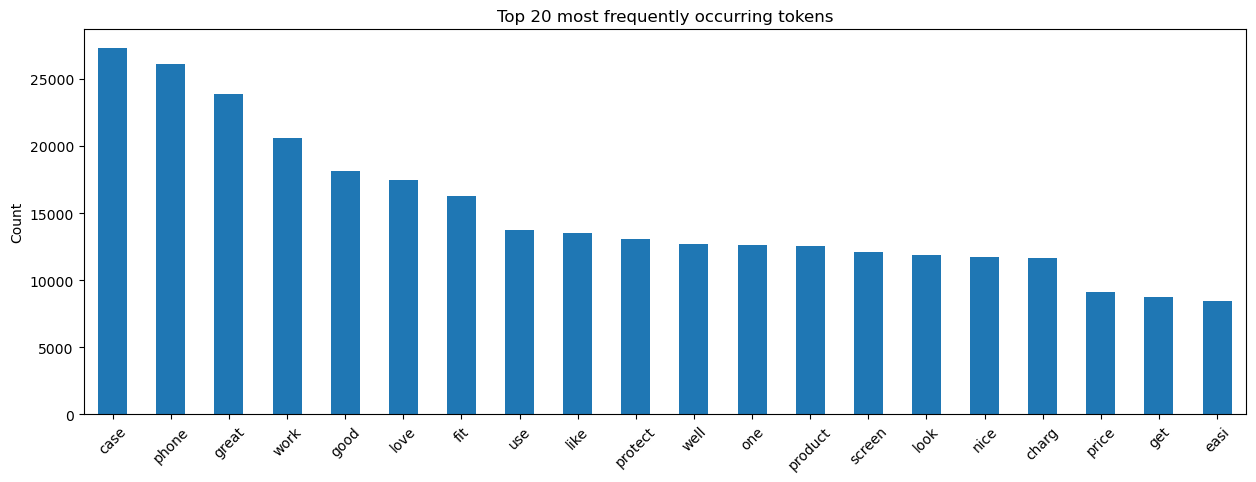

In [32]:
# frequency of 1-grams, most reviews are positive  
word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("Top 20 most frequently occurring tokens")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

In [33]:
word_counts

,counts
case,27326.395414
phone,26152.251815
great,23903.013353
work,20638.696059
good,18108.332234
...,...
vent,718.557082
point,712.485670
happen,694.467249
contact,687.829628


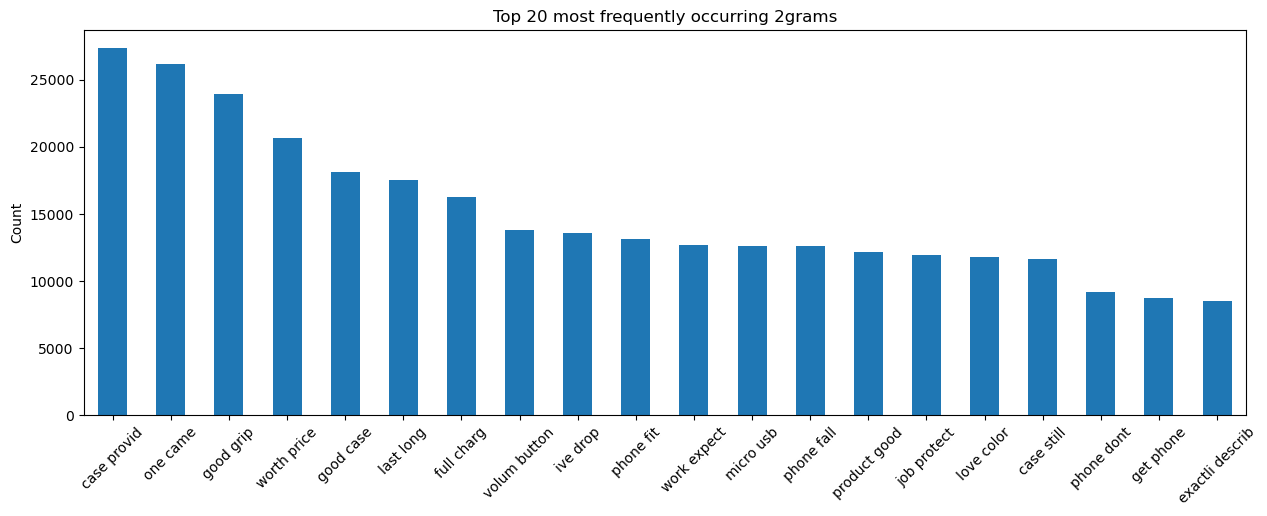

In [34]:
word_counts_2grams.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("Top 20 most frequently occurring 2grams")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

In [35]:
word_counts_2grams

,counts
case provid,27326.395414
one came,26152.251815
good grip,23903.013353
worth price,20638.696059
good case,18108.332234
...,...
wallet case,718.557082
perfect fit,712.485670
good price,694.467249
coupl time,687.829628


Let's understand the word counts for single tokens in terms of spelling error

In [36]:
feat = tfidf.get_feature_names_out()

In [37]:
english_words = set(nltk.corpus.words.words())

stemmed_english_list = []
for i in english_words:
    token = PorterStemmer().stem(i)
    stemmed_english_list.append(token)


In [39]:
len(stemmed_english_list)

235892

Here we can see 16% of tokens not recognised in stemmed english language.

In [40]:
unrecognized_tokens = [token for token in feat if token.lower() not in stemmed_english_list]
num_unrec = len(unrecognized_tokens)
num_unrec/len(feat)

0.048

In [43]:
unrecognized_word_counts = word_counts[word_counts.index.isin(unrecognized_tokens)]
print(f"Unrecognised words: {len(unrecognized_word_counts)}")
unrecognized_word_counts.sort_values(by = 'counts', ascending=False).head(5)

Unrecognised words: 24


,counts
iphon,7205.540295
ive,4237.094242
im,4119.922418
samsung,3339.025634
otterbox,2301.878232


In [44]:
unrecognized_word_counts.describe()

,counts
count,24.000000
mean,1786.349194
std,1517.292386
min,792.600605
25%,1000.821861
50%,1112.827308
75%,1602.972797
max,7205.540295


In [45]:
unrecognized_word_counts.quantile(0.99)

counts    6522.797703
Name: 0.99, dtype: float64

In [46]:
unrecognized_word_counts.head(10)

,counts
iphon,7205.540295
ive,4237.094242
im,4119.922418
samsung,3339.025634
otterbox,2301.878232
usb,2138.570660
isnt,1424.440176
s5,1390.114830
ipad,1288.681153
lg,1267.406219


Here we can get the vectorised versions of the reviews boths as 1-grams and 2-grams:

In [47]:
# 1-grams vec
review_vectors = tfidf.transform(shorter["reviewText"].fillna(''))


In [48]:
# to a datagrame
review_vectors_df = pd.DataFrame(review_vectors.toarray(), columns=tfidf.get_feature_names_out())


In [49]:
# merge with reviews
output_df = pd.concat([shorter, review_vectors_df], axis=1)

In [50]:
output_df.head(3)

,overall,reviewText,asin,length,binary,10,100,6s,abl,absolut,...,wont,work,worri,worth,would,wouldnt,wrong,year,yet,your
0,5.0,Looks even better in person. Be careful to not...,7508492919,271,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,5.0,When you don't want to spend a whole lot of ca...,7508492919,102,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,3.0,"so the case came on time, i love the design. I...",7508492919,257,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.206804,0.0


In [52]:
# 2-grams vec
review_vectors_2grams = tfidf_2grams.transform(shorter["reviewText"].fillna(''))


In [53]:
# to a datagrame
review_vectors_df_2grams = pd.DataFrame(review_vectors_2grams.toarray(), columns=tfidf_2grams.get_feature_names_out())


In [54]:
# merge with reviews
output_df_2grams = pd.concat([shorter, review_vectors_df_2grams], axis=1)

In [55]:
output_df_2grams.head(3)

,overall,reviewText,asin,length,binary,6s plu,absolut love,add bulk,add much,air bubbl,...,worth money,worth price,would buy,would definit,would highli,would like,would purchas,would recommend,would work,year old
0,5.0,Looks even better in person. Be careful to not...,7508492919,271,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5.0,When you don't want to spend a whole lot of ca...,7508492919,102,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.0,"so the case came on time, i love the design. I...",7508492919,257,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


we can pickle the full dataframe ready for modelling

In [58]:
output_df.to_pickle("../data/reviews_vector_1grams.pkl")

In [59]:
output_df_2grams.to_pickle("../data/reviews_vector_2grams.pkl")